# Introduction to Machine Learning using Muon Tracks in CMS - worked example  
This is a worked example of the Coding Camp 2 activity. Analysis is based on [Natasha Holmes' weighted chi-sq](https://docs.google.com/document/d/1VP2fAFiVm1FqjqD4D-jRctjdIrMiSmBWAYw_cqBhxV0/edit?usp=sharing)

## Problem  
How does the magnetic field in CMS affect a muon's trajectory? Can we use machine learning to improve our fitting techniques?  

## Plan  
Use machine learning linear regression techniques to fit model functions to CMS tracker data for a muon and evaluate using weighted chi-sq. This is based on the Muon Tracks activity with machine learning application.

## Data  
For muon track 1, pt = 25 GeV, particle is a muon with q= -1. muon_track_1.csv has 3 rows of header info to ignore for analysis as a pandas dataframe. Data include x,y coordinates of the muon's trajectory but not z. The tracker has a spatial resolution on the order of 0.5 cm due to physical size of the hardware elements.  

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy.optimize import curve_fit

In [35]:
track = pd.read_csv('../data/muon_track_1.csv', skiprows=2)
track.head()

,x,y
0,0.038726,-0.015958
1,0.131212,-0.055478
2,0.223866,-0.094564
3,0.316684,-0.133215
4,0.409664,-0.171429


## Analysis  


In [63]:
# fit a linear model to a set of muon tracks in CMS

def linear_model(x, m, b):   # x and y are track coordinates, scipy will optimize m & b to fit
    y = m * x + b
    return(y)

popt, pcov = curve_fit(linear_model, track['x'], track['y'])
linear_params = popt
linear_params

array([-0.3862925 , -0.01158637])

## Linear Regression

We will use the function LinearRegression from the sklearn library to fit a linear regression model. The array must be 2D so we will reshape the data before fitting. See more details on the function and the format of the input [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)


In [79]:
# fit a linear model to a set of muon tracks in CMS
from sklearn.linear_model import LinearRegression

X = track['x'].values.reshape(-1, 1)
Y = track['y'].values.reshape(-1, 1)

lin_reg = LinearRegression()
lin_reg.fit(X,Y)

regg_params = lin_reg.coef_, lin_reg.intercept_
regg_params

(array([[-0.3862925]]), array([-0.01158637]))

## Linear Model Fitting using Stochastic Gradient Descent

We will use SGDRegressor from the sklearn library to implement machine learning techniques (specifically Stochastic Gradient Descent) to fit the linear model. SGD stands for Stochastic Gradient Descent: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). More details about the function can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)

In [145]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, eta0=1.1, random_state=42)
sgd_reg.fit(X,Y.ravel())
sgd_params = sgd_reg.coef_, sgd_reg.intercept_
sgd_params

(array([-0.38505106]), array([-0.01110425]))

In [146]:
# circular curvature using classical Lorentz force
# for a circle with center at r, theta from the origin: y r*sin(theta)-sqrt(r^2-(x-r*cos(theta))^2)
def curved_model(x, r, theta):   # x and y are track coordinates, scipy will optimize r & theta to fit
    y = r*np.sin(theta)-np.sqrt(r**2-(x-r*np.cos(theta))**2)
    return(y)

popt, pcov = curve_fit(curved_model, track['x'], track['y'], p0=[30,1])
curved_params = popt
curved_params

array([38.3218896 ,  1.17386382])

In [147]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y)
poly_regg_params = lin_reg.coef_, lin_reg.intercept_
poly_regg_params

(array([[-0.41220111,  0.01327689]]), array([-0.00323752]))

In [ ]:
#Lasso
#Ridge

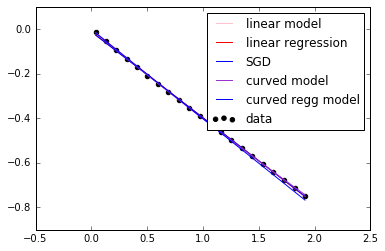

,x,y,linear model yvals,curved model yvals,linear regg model yvals,linear model residuals,curved model residuals,linear regg model residuals
0,0.038726,-0.015958,-0.026546,-0.016208,-0.026546,0.010588,0.000251,0.010588
1,0.131212,-0.055478,-0.062273,-0.054716,-0.062273,0.006795,-0.000762,0.006795
2,0.223866,-0.094564,-0.098064,-0.093009,-0.098064,0.003500,-0.001555,0.003500
3,0.316684,-0.133215,-0.133919,-0.131086,-0.133919,0.000704,-0.002129,0.000704
4,0.409664,-0.171429,-0.169837,-0.168946,-0.169837,-0.001592,-0.002483,-0.001592


In [140]:
# compare the two models using chi-sq

# plotting the original data and the optimized model (i.e., trendline)
plt.scatter(track['x'], track['y'], label="data", color='k')
plt.plot(track['x'], linear_model(track['x'], linear_params[0], linear_params[1]), label="linear model", color='pink')
plt.plot(track['x'], linear_model(track['x'], regg_params[0][0][0],regg_params[1][0]), label="linear regression",color='red')
plt.plot(track['x'], linear_model(track['x'], sgd_params[0],sgd_params[1]), label="SGD",color='blue')
plt.plot(track['x'], curved_model(track['x'], curved_params[0], curved_params[1]), label="curved model", color='darkorchid')
#plt.plot(track['x'], (poly_regg_params[0][0][0]*track['x'] squared + poly_regg_params[0][0][1]*track['x'] + poly_regg_params[1]), label="curved regg model")


plt.legend()
plt.show()

track['linear model yvals'] = linear_model(track['x'], linear_params[0], linear_params[1])
track['curved model yvals'] = curved_model(track['x'], curved_params[0], curved_params[1])
track['linear regg model yvals'] = linear_model(track['x'], regg_params[0][0][0],regg_params[1][0])

track['linear model residuals'] = track['y'] - track['linear model yvals']
track['curved model residuals'] = track['y'] - track['curved model yvals']
track['linear regg model residuals'] = track['y'] - track['linear regg model yvals']


track.head()

## Conclusion  
